In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

pd.options.display.max_columns = 120


In [3]:
def load_data(file_path):
    """Load data from a CSV file into a pandas DataFrame."""
    return pd.read_csv(file_path)

In [4]:
train_dir = Path("../data_sync/outputs/Training_and_validation_set/NR")
train_files = list(train_dir.glob("*.csv"))
print(f"Training files: {len(train_files)}")

test_dir = Path("../data_sync/outputs/Test_set/NR")
test_files = list(test_dir.glob("*.csv"))
print(f"Test files: {len(test_files)}")     

Training files: 10
Test files: 2


In [5]:
# Parameters regarding how far back in time to feed
history = 10
lag = 5
output_col = "Gear"

In [6]:
info_columns = ['tt_s', 'Lap', 'Gear', 'ns1:LatitudeDegrees', 'ns1:LongitudeDegrees', 'Sport'] 
feature_columns_pole_data = ['speed_kmph', 'power_w', 'frequency_ppm', 'thrust_left_ms', 'thrust_right_ms', 'impulse_left_ns', 'impulse_right_ns', 'force_meanl_n', 'force_meanr_n', 'f_tot_mean_n']
feature_columns_gnss = ['ns1:AltitudeMeters', 'ns2:Speed', 'ns2:RunCadence', 'ns2:Watts']

feature_columns = feature_columns_pole_data + feature_columns_gnss

In [7]:
dfs = [load_data(file) for file in train_files]
test_dfs = [load_data(file) for file in test_files]

def make_sure_numeric(df, columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

dfs = [make_sure_numeric(df, feature_columns_gnss + feature_columns_pole_data) for df in dfs]
test_dfs = [make_sure_numeric(df, feature_columns_gnss + feature_columns_pole_data) for df in test_dfs]

In [8]:
def add_ratios(df):
    df = df.copy()
    df["force_ratio"] = df["force_meanl_n"]/(df["force_meanl_n"] + df["force_meanr_n"] + 1e-6)
    df["thrust_ratio"] = df["thrust_left_ms"]/(df["thrust_left_ms"] + df["thrust_right_ms"] + 1e-6)
    df["impulse_ratio"] = df["impulse_left_ns"]/(df["impulse_left_ns"] + df["impulse_right_ns"] + 1e-6)
    return df

dfs = [add_ratios(df) for df in dfs]
test_dfs = [add_ratios(df) for df in test_dfs]
feature_columns = feature_columns_pole_data + feature_columns_gnss + ["force_ratio", "thrust_ratio", "impulse_ratio"]

In [9]:
def create_lagged_features(df, feature_columns, history, lag):
    df = df.copy()
    for h in range(1, lag + 1):
        for col in feature_columns:
            df[f"{col}_lag{h}"] = df[col].shift(h)
    for h in range(history):
        for col in feature_columns:
            df[f"{col}_mean"] = df[col].shift(h).rolling(window=lag).mean()
            df[f"{col}_std"] = df[col].shift(h).rolling(window=lag).std()
    df = df.dropna().reset_index(drop=True)
    return df

dfs = [create_lagged_features(df, feature_columns, history, lag) for df in dfs]
test_dfs = [create_lagged_features(df, feature_columns, history, lag) for df in test_dfs]

feature_columns_lagged = []
for h in range(1, lag + 1):
    for col in feature_columns:
        feature_columns_lagged.append(f"{col}_lag{h}")
for col in feature_columns:
        feature_columns_lagged.append(f"{col}_mean")
        feature_columns_lagged.append(f"{col}_std")
feature_columns = feature_columns + feature_columns_lagged


/var/folders/js/3kl4pzld50qdxyxznqpfnbz00000gn/T/ipykernel_64232/133474891.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_mean"] = df[col].shift(h).rolling(window=lag).mean()
/var/folders/js/3kl4pzld50qdxyxznqpfnbz00000gn/T/ipykernel_64232/133474891.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_std"] = df[col].shift(h).rolling(window=lag).std()
/var/folders/js/3kl4pzld50qdxyxznqpfnbz00000gn/T/ipykernel_64232/133474891.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the 

In [10]:
def add_acceleration(df):
    df = df.copy()
    df['acceleration'] = df['ns2:Speed'].diff()
    df['acceleration'].fillna(0, inplace=True)
    return df
dfs = [add_acceleration(df) for df in dfs]
test_dfs = [add_acceleration(df) for df in test_dfs]
feature_columns.append('acceleration')

/var/folders/js/3kl4pzld50qdxyxznqpfnbz00000gn/T/ipykernel_64232/1663801313.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['acceleration'].fillna(0, inplace=True)
/var/folders/js/3kl4pzld50qdxyxznqpfnbz00000gn/T/ipykernel_64232/1663801313.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

In [12]:
def _stable_indices(y, n=2):
    """Return positional indices where the label has been stable for n before and n after."""
    y = y.reset_index(drop=True)
    idx = []
    for i in range(n, len(y) - n):
        c = y.iloc[i]
        # use iloc for positional comparisons
        if all(y.iloc[i - j] == c and y.iloc[i + j] == c for j in range(1, n + 1)):
            idx.append(i)
    return idx

def accuracy_when_stable_gear(y, pred, n=2):
    y = y.reset_index(drop=True)
    pred = np.asarray(pred)
    idx = _stable_indices(y, n)
    if len(idx) == 0:
        return np.nan
    return np.mean(y.iloc[idx].values == pred[idx])

def classification_report_when_stable_gear(y, pred, n=2):
    y = y.reset_index(drop=True)
    pred = np.asarray(pred)
    idx = _stable_indices(y, n)
    if len(idx) == 0:
        return "No stable segments found."
    return classification_report(y.iloc[idx], pred[idx], labels=ALL_LABELS, zero_division=0)

def confusion_matrix_when_stable_gear(y, pred, n=2):
    y = y.reset_index(drop=True)
    pred = np.asarray(pred)
    idx = _stable_indices(y, n)
    if len(idx) == 0:
        return None
    return confusion_matrix(y.iloc[idx], pred[idx], labels=ALL_LABELS)

In [13]:
train_df = pd.concat(dfs, ignore_index=True)
print(f"Training data shape: {train_df.shape}")
test_df = pd.concat(test_dfs, ignore_index=True)
print(f"Test data shape: {test_df.shape}")

Training data shape: (11141, 143)
Test data shape: (2393, 143)


In [14]:
def XY(df, feature_columns):
    X = df[feature_columns]
    Y = df[output_col]
    return X, Y

In [15]:
# Uncomment to not use the engineered features
feature_columns = feature_columns_pole_data + feature_columns_gnss

In [16]:
X_train, y_train = XY(train_df, feature_columns)
X_test, y_test = XY(test_df, feature_columns)

Training tuned Random Forest...
Out-of-bag score: 0.8760

TUNED MODEL - Training Performance
              precision    recall  f1-score   support

         0.0       0.93      0.91      0.92      2247
        2.0H       0.91      0.99      0.95      1103
        2.0V       0.95      1.00      0.97       548
         3.0       0.98      0.95      0.96      5772
         4.0       0.87      0.94      0.91      1471

    accuracy                           0.95     11141
   macro avg       0.93      0.96      0.94     11141
weighted avg       0.95      0.95      0.95     11141

Out-of-bag score: 0.8760

TUNED MODEL - Training Performance
              precision    recall  f1-score   support

         0.0       0.93      0.91      0.92      2247
        2.0H       0.91      0.99      0.95      1103
        2.0V       0.95      1.00      0.97       548
         3.0       0.98      0.95      0.96      5772
         4.0       0.87      0.94      0.91      1471

    accuracy                   

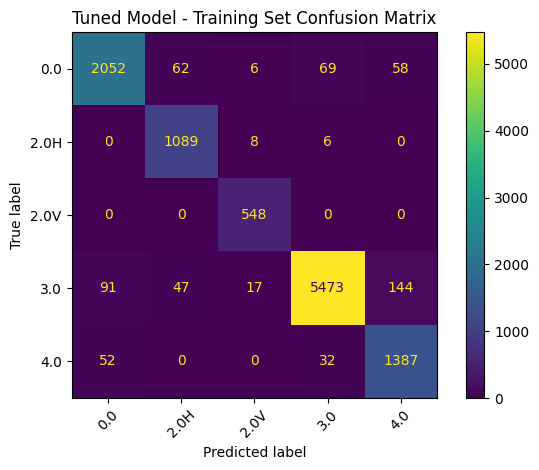


Performance when gear is stable
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95      1830
        2.0H       0.92      0.99      0.96       959
        2.0V       0.97      1.00      0.98       473
         3.0       0.99      0.98      0.98      5181
         4.0       0.92      0.98      0.95      1058

    accuracy                           0.97      9501
   macro avg       0.96      0.98      0.97      9501
weighted avg       0.97      0.97      0.97      9501

              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95      1830
        2.0H       0.92      0.99      0.96       959
        2.0V       0.97      1.00      0.98       473
         3.0       0.99      0.98      0.98      5181
         4.0       0.92      0.98      0.95      1058

    accuracy                           0.97      9501
   macro avg       0.96      0.98      0.97      9501
weighted avg       0.97      0.97      0.97 

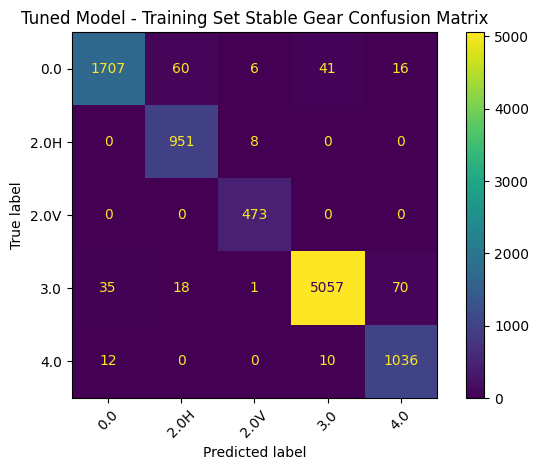


TUNED MODEL - Test Performance
              precision    recall  f1-score   support

         0.0       0.86      0.90      0.88       391
        2.0H       0.83      0.92      0.87       190
        2.0V       0.86      0.86      0.86       170
         3.0       0.92      0.87      0.89      1414
         4.0       0.43      0.51      0.47       228

    accuracy                           0.84      2393
   macro avg       0.78      0.81      0.79      2393
weighted avg       0.85      0.84      0.85      2393


              precision    recall  f1-score   support

         0.0       0.86      0.90      0.88       391
        2.0H       0.83      0.92      0.87       190
        2.0V       0.86      0.86      0.86       170
         3.0       0.92      0.87      0.89      1414
         4.0       0.43      0.51      0.47       228

    accuracy                           0.84      2393
   macro avg       0.78      0.81      0.79      2393
weighted avg       0.85      0.84      0.85 

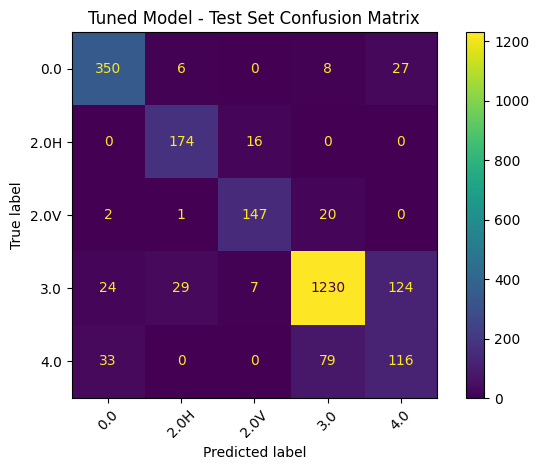


Performance when gear is stable
              precision    recall  f1-score   support

         0.0       0.92      0.95      0.94       311
        2.0H       0.90      0.93      0.91       174
        2.0V       0.90      0.95      0.93       146
         3.0       0.96      0.89      0.92      1306
         4.0       0.36      0.57      0.44       123

    accuracy                           0.89      2060
   macro avg       0.81      0.86      0.83      2060
weighted avg       0.91      0.89      0.89      2060



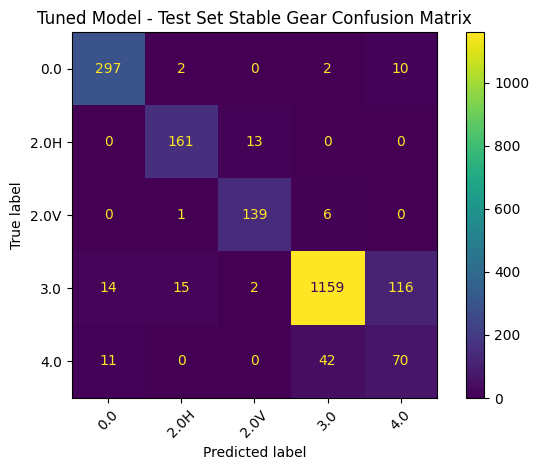

In [17]:
ALL_LABELS = sorted(y_train.unique())

rf_tuned = RandomForestClassifier(
    n_estimators=200,              # Tress
    max_depth=15,                  # Tree depth
    min_samples_split=10,          # Samples needed for a split
    min_samples_leaf=4,            # Samples needed for a leaf
    max_features='sqrt',           # Use sqrt(n_features) per split (adds randomness)
    class_weight='balanced',       # Keep this for class imbalance
    bootstrap=True,                # Enable bootstrapping
    oob_score=True,                # Get out-of-bag score (free validation estimate)
    n_jobs=-1,
    random_state=42
)

print("Training tuned Random Forest...")
rf_tuned.fit(X_train, y_train)
print(f"Out-of-bag score: {rf_tuned.oob_score_:.4f}")

pred_train = rf_tuned.predict(X_train)
pred_test = rf_tuned.predict(X_test)

print("\n" + "="*50)
print("TUNED MODEL - Training Performance")
print("="*50)
print(classification_report(y_train, pred_train))
# Confusion matrix
cm = confusion_matrix(y_train, pred_train, labels=sorted(y_train.unique()))
ConfusionMatrixDisplay(cm, display_labels=ALL_LABELS).plot(xticks_rotation=45)
plt.title("Tuned Model - Training Set Confusion Matrix")
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("Performance when gear is stable")
print("="*50)
print(classification_report_when_stable_gear(y_train, pred_train))
# Confusion matrix
cm = confusion_matrix_when_stable_gear(y_train, pred_train)
ConfusionMatrixDisplay(cm, display_labels=ALL_LABELS).plot(xticks_rotation=45)
plt.title("Tuned Model - Training Set Stable Gear Confusion Matrix")
plt.tight_layout()
plt.show()


print("\n" + "="*50)
print("TUNED MODEL - Test Performance")
print("="*50)
print(classification_report(y_test, pred_test))
print("\n" + "="*50)
# Confusion matrix
cm = confusion_matrix(y_test, pred_test, labels=sorted(y_train.unique()))
ConfusionMatrixDisplay(cm, display_labels=ALL_LABELS).plot(xticks_rotation=45)
plt.title("Tuned Model - Test Set Confusion Matrix")
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("Performance when gear is stable")
print("="*50)
print(classification_report_when_stable_gear(y_test, pred_test))
# Confusion matrix
cm = confusion_matrix_when_stable_gear(y_test, pred_test)
ConfusionMatrixDisplay(cm, display_labels=ALL_LABELS).plot(xticks_rotation=45)
plt.title("Tuned Model - Test Set Stable Gear Confusion Matrix")
plt.tight_layout()
plt.show()


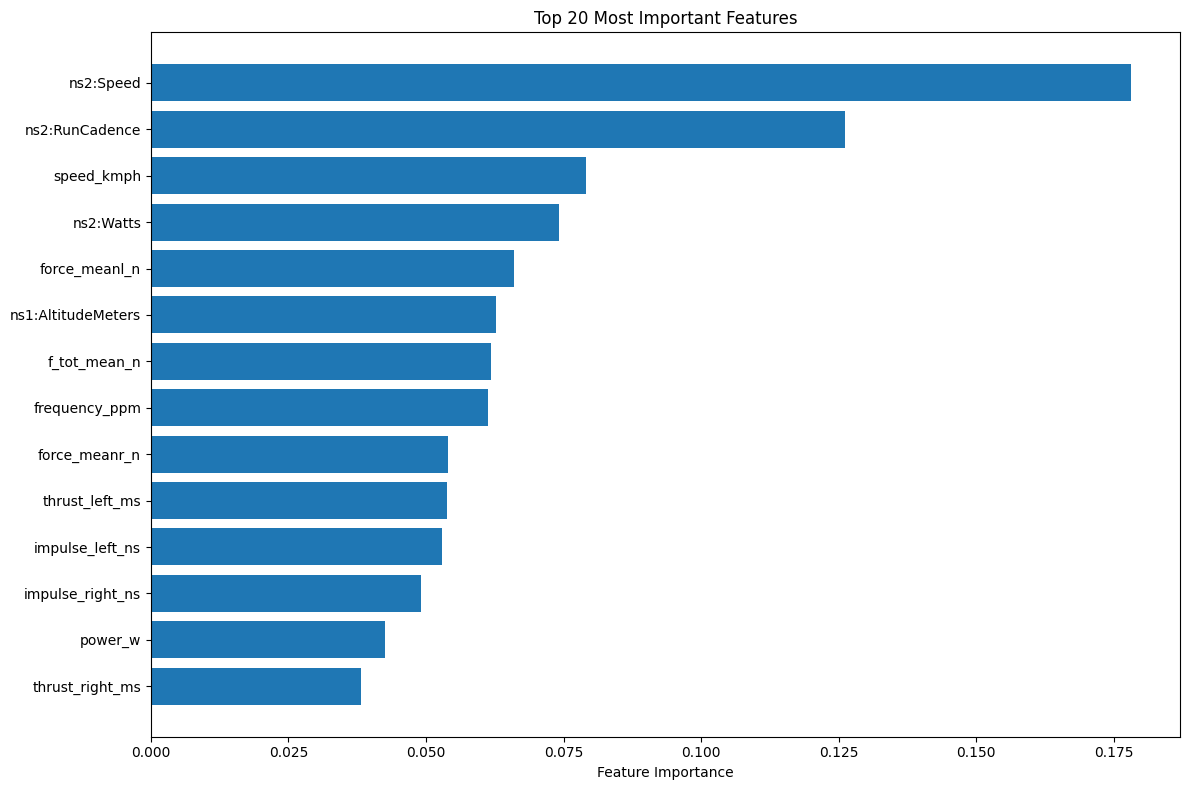


Top 10 most important features:
               feature  importance
11           ns2:Speed    0.178115
12      ns2:RunCadence    0.126147
0           speed_kmph    0.079039
13           ns2:Watts    0.074101
7        force_meanl_n    0.066081
10  ns1:AltitudeMeters    0.062649
9         f_tot_mean_n    0.061802
2        frequency_ppm    0.061354
8        force_meanr_n    0.053973
3       thrust_left_ms    0.053865


In [18]:
# Analyze feature importance to understand what drives predictions
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_tuned.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 most important features
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 most important features:")
print(feature_importance.head(10))

MLP — Train
              precision    recall  f1-score   support

         0.0       0.84      0.83      0.84      2247
        2.0H       0.88      0.92      0.90      1103
        2.0V       0.90      0.90      0.90       548
         3.0       0.90      0.94      0.92      5772
         4.0       0.82      0.69      0.75      1471

    accuracy                           0.88     11141
   macro avg       0.87      0.86      0.86     11141
weighted avg       0.88      0.88      0.88     11141



/Users/gustafbjorn/Documents/Chalmers/CAS/TRA300 Digitalization in sports/Project/Project/tra300-ski-technique-classification/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


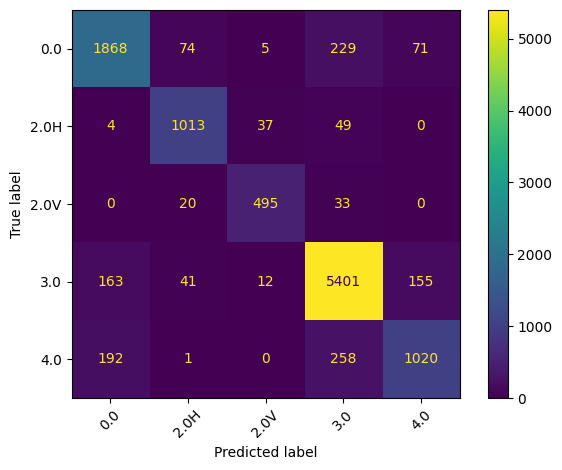

Stable gears
              precision    recall  f1-score   support

         0.0       0.90      0.84      0.87      1830
        2.0H       0.90      0.96      0.93       959
        2.0V       0.92      0.94      0.93       473
         3.0       0.94      0.96      0.95      5181
         4.0       0.88      0.80      0.84      1058

    accuracy                           0.92      9501
   macro avg       0.91      0.90      0.90      9501
weighted avg       0.92      0.92      0.92      9501

              precision    recall  f1-score   support

         0.0       0.90      0.84      0.87      1830
        2.0H       0.90      0.96      0.93       959
        2.0V       0.92      0.94      0.93       473
         3.0       0.94      0.96      0.95      5181
         4.0       0.88      0.80      0.84      1058

    accuracy                           0.92      9501
   macro avg       0.91      0.90      0.90      9501
weighted avg       0.92      0.92      0.92      9501



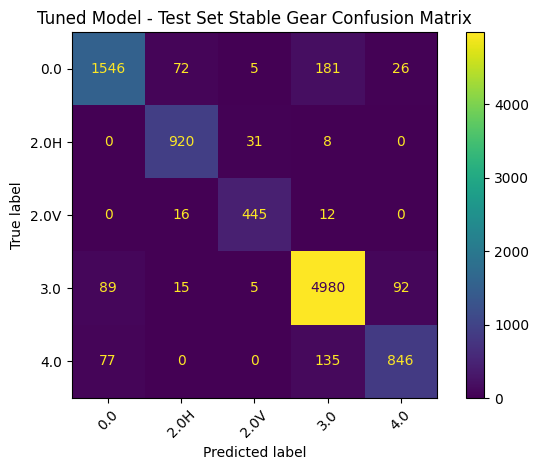

MLP — Test
              precision    recall  f1-score   support

         0.0       0.74      0.95      0.83       391
        2.0H       0.86      0.88      0.87       190
        2.0V       0.84      0.87      0.86       170
         3.0       0.92      0.92      0.92      1414
         4.0       0.52      0.24      0.33       228

    accuracy                           0.85      2393
   macro avg       0.77      0.77      0.76      2393
weighted avg       0.84      0.85      0.84      2393



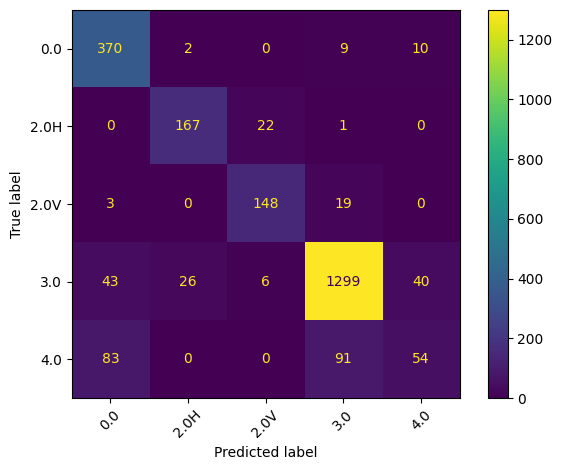

Stable gears
              precision    recall  f1-score   support

         0.0       0.82      0.98      0.89       311
        2.0H       0.91      0.89      0.90       174
        2.0V       0.87      0.95      0.91       146
         3.0       0.95      0.94      0.95      1306
         4.0       0.49      0.29      0.37       123

    accuracy                           0.90      2060
   macro avg       0.81      0.81      0.80      2060
weighted avg       0.90      0.90      0.90      2060

              precision    recall  f1-score   support

         0.0       0.82      0.98      0.89       311
        2.0H       0.91      0.89      0.90       174
        2.0V       0.87      0.95      0.91       146
         3.0       0.95      0.94      0.95      1306
         4.0       0.49      0.29      0.37       123

    accuracy                           0.90      2060
   macro avg       0.81      0.81      0.80      2060
weighted avg       0.90      0.90      0.90      2060



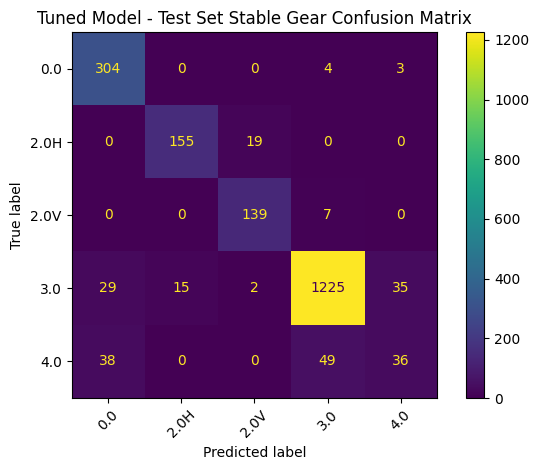

In [19]:
mlp = MLPClassifier(
    hidden_layer_sizes=(128,64), activation="relu",
    batch_size=256, max_iter=50, learning_rate="adaptive",
    random_state=42
)
mlp.fit(X_train, y_train)
pred_test_mlp = mlp.predict(X_test)
pred_train_mlp = mlp.predict(X_train)

print("MLP — Train")
print(classification_report(y_train, pred_train_mlp))
cm = confusion_matrix(y_train, pred_train_mlp, labels=sorted(y_train.unique()))
ConfusionMatrixDisplay(cm, display_labels=ALL_LABELS).plot(xticks_rotation=45)
plt.tight_layout(); plt.show()

print("Stable gears")
print(classification_report_when_stable_gear(y_train, pred_train_mlp))
# Confusion matrix
cm = confusion_matrix_when_stable_gear(y_train, pred_train_mlp)
ConfusionMatrixDisplay(cm, display_labels=ALL_LABELS).plot(xticks_rotation=45)
plt.title("Tuned Model - Test Set Stable Gear Confusion Matrix")
plt.tight_layout()
plt.show()


print("MLP — Test")
print(classification_report(y_test, pred_test_mlp))
cm = confusion_matrix(y_test, pred_test_mlp, labels=sorted(y_train.unique()))
ConfusionMatrixDisplay(cm, display_labels=ALL_LABELS).plot(xticks_rotation=45)
plt.tight_layout(); plt.show()


print("Stable gears")
print(classification_report_when_stable_gear(y_test, pred_test_mlp))
# Confusion matrix
cm = confusion_matrix_when_stable_gear(y_test, pred_test_mlp)
ConfusionMatrixDisplay(cm, display_labels=ALL_LABELS).plot(xticks_rotation=45)
plt.title("Tuned Model - Test Set Stable Gear Confusion Matrix")
plt.tight_layout()
plt.show()


